In this research the Worldbank data on international development will be analyzed.
Due to the sheer number of indicators (features), the task of finding out patterns on the whole dataset is of extreme complexity. The indicators are from different fields (macroeconomics, social, ecology, etc.), many of them are a combination of other indicators (GDP, GDP per capita, % of GDP), or the same indicator in different units (local currency real, local currency nominal, PPP, US$); also, the data is itself combined from different sources and its availability (percentage of available values) can vary drastically by country, year and indicator. In addition, many of macroeconomic indicators have a tendency to auto-correlate or inter-correlate if compared by nominal values. Therefore, it was decided to manually choose a field of research and the resulting indicator (target label).

I: Target label (TL) - life expectancy:
- one of the core sociological indicators.
- subject to influence by many factors.
- measured as an estimation based on mortality ratio over one year, so less/no lag is expected when looking for correlations.

Main features: will be found in the process of researching data. After removing the least available features (based on share of N/A), we will manually choose the ones that might have explainatory power, after that test it by calculating correlation.

In [205]:
%matplotlib inline

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib as plt
import statsmodels.regression.linear_model as sm_lm
import statsmodels.stats.outliers_influence as sm_ol
import statsmodels.stats.diagnostic as sm_diag
from statsmodels.tools.tools import add_constant
import scipy
import math
import os, gc
import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', 60)
pd.set_option('display.max_rows', 200)
pd.set_option('display.float_format', lambda x: '%.3f' % x)

In [ ]:
dataset1 = os.listdir("../input")
dataset1 = list(filter(lambda x: x not in ['countries.csv', 'selected indicators.xlsx', 'definitions.csv', 'data2.xlsx'], dataset1))
df_list = [pd.read_csv("../input/"+f) for f in dataset1]
df = pd.concat(df_list, ignore_index=False, axis=1)
df_ctr=pd.read_csv("../input/countries.csv")
ctr=df_ctr['Country Name'].values.tolist()

print(dataset1)
print(df.shape)
print(len(ctr))

II: clearing the data.
Currently the dataset contains ((264 countries x 1599 indicators + 5 technical fields) x (59 periods + 12 country/indicator columns)) = 422141 x 71 data units.

The goal is to leave as many countries, and as many years as possible. Indicators will have their number reduced the most.

Deleting duplicate headers columns and technical fields, sort by year.

Note that this was done in several iterations, by checking which country-indicators and/or year-indicators with least availability, correlation to the TL and both. Shown is only the final version.

In [ ]:
df=df.drop(df.index[[-1,-2,-3,-4,-5]])
df = df.loc[:,~df.columns.duplicated()]
df = df.reindex(sorted(df.columns), axis=1)
df=df.iloc[::,::-1]
print(df.shape)

In [ ]:
df.head(3)

Groups of countries are linear combinations of data available in the rest of the dataset, so we delete them. First we check if all country names are read correctly and are present in the dataset.

In [ ]:
tmp=df['Country Name'].values.tolist()
df_ctr=df_ctr[~df_ctr['Country Name'].isin(tmp)]
print(df_ctr.head())

In [ ]:
df=df[df['Country Name'].isin(ctr)]
print(df.shape)

In [ ]:
df.isna().sum()/(df.isna().sum()+df.notna().sum())

press 'Output' to show

Earlier and the most recent periods have far less data available, those are likely to be dropped.

Rearranging the data into multiindex pivot table.

In [ ]:
df=df.melt(id_vars=['Country Name', 'Series Name'])
df.rename(columns={'variable': 'Year'}, inplace=True)
df = df.pivot_table(index='Series Name', columns=['Country Name', 'Year'], dropna = False)
df.head(2)

In [ ]:
df.shape

(1599 indicators x (217 countries x 59 periods))

In [ ]:
df.isna().sum(axis=1)/(df.isna().sum(axis=1)+df.notna().sum(axis=1))

press 'Output' to show

The core indicators: life expextancy, mortality rate and GDP are widely available - less than 30% of values are missing (although GDP PPP is not, so we will have to rely on GDP in US$, for international comparability. Not ideal, but should suffice). Most of the education and healthcare - related data are also sparcely available, so the model will have to do with more indirect estimation.

Since we have 60 observation per country-indicator, the threshhold to drop indicators is set to 50%, so we can hopefully leave about 30 observations on average.

In [ ]:
df=df.dropna(axis=0, thresh=6402)
df.shape

Now that the data is more visually interpretable, we can use a table of % data missing for each year-indicator.

In [ ]:
df.isna().sum(axis=1, level="Year")/(df.isna().sum(axis=1, level="Year")+df.notna().sum(axis=1, level="Year"))

press 'Output' to show

Removing years up to 1993 as well as 2017-18 due to low data availability, then we choose features based on their supposed relation to the TL and availability, as well as general indicators such as population, GDP, land area, to calculate relative values. Leaving 1 extra year (1994) to calculate inflation based on CPI, it will be removed afterwards.

In [ ]:
ldrop = [str(i) for i in range(1960,1994)]
ldrop.append("2017")
ldrop.append("2018")
df=df.drop(columns=ldrop, level="Year")
ids = ['Adjusted savings: education expenditure (% of GNI)', 'Adolescent fertility rate (births per 1,000 women ages 15-19)',
      'Age dependency ratio (% of working-age population)', 'Agricultural land (% of land area)', 'Agriculture, forestry, and fishing, value added (% of GDP)',
       'Birth rate, crude (per 1,000 people)', 'Cereal production (metric tons)', 'Consumer price index (2010 = 100)', 'Death rate, crude (per 1,000 people)',
      'Fertility rate, total (births per woman)', 'GDP (constant 2010 US$)', 'Immunization, measles (% of children ages 12-23 months)', 'Land area (sq. km)', 'Land under cereal production (hectares)',
      'Life expectancy at birth, total (years)', 'Lower secondary school starting age (years)', 'Military expenditure (% of GDP)', 'Manufacturing, value added (% of GDP)', 
      'Mobile cellular subscriptions (per 100 people)', 'Population, total', 'Preprimary education, duration (years)', 'Primary education, duration (years)', 
      'Rural population (% of total population)', 'School enrollment, primary (% gross)', 'Services, value added (% of GDP)']
print(len(ids))
print(len(ids)-len(set(ids)))
df=df[df.index.isin(ids)]
df.shape

In [ ]:
df_t=(df.isna().sum(axis=1, level="Country Name")/(df.isna().sum(axis=1, level="Country Name")+df.notna().sum(axis=1, level="Country Name"))).T

In [ ]:
df_t

press 'Output' to show

As we can see, countries that have a non-zero share of missing TL values generally have low number of observations on other indicators, so we are safe to drop any country which misses at least some TL observations.

Removing countries with high share of other missing indicators as well

In [ ]:
ldrop=df_t.loc[df_t['Life expectancy at birth, total (years)']!=0].index.tolist()
ldrop+=df_t.loc[df_t['Immunization, measles (% of children ages 12-23 months)']!=0].index.tolist()
ldrop+=df_t.loc[df_t['GDP (constant 2010 US$)']>0.3].index.tolist()
ldrop+=df_t.loc[df_t['Consumer price index (2010 = 100)']>0.3].index.tolist()
ldrop+=df_t.loc[df_t['Agriculture, forestry, and fishing, value added (% of GDP)']>0.15].index.tolist()
del df_t
gc.collect()
print(set(ldrop))
df=df.drop(columns=ldrop, level="Country Name")
df.shape

III: Hypotheses:
- Check the distribution of features. Normal distribution is expected, otherwise the data will need to be transformed if we want to use maximum likelyhood estimation or anything else that requires ~N dist of variables.
- Test the set of features for autocorrelation. Expected to have one, especially in GDP - related series.
- Test the data for heteroskedasticity. Same, expected to be present in series with a growth trend.
- Test the other variables for cross-correlation.
- TL by definition is based on mortality rate, so high correlation between the two is expected. Otherwise may suggest inconsistency in data/methodology or other errors.
- Other selected features except for auxiliary ones such as GDP, land area, cereal production are expected to have correlation with TL.

TL density function:

In [ ]:
df=df.T

In [ ]:
sns.distplot(df['Life expectancy at birth, total (years)']);

Correlation matrix:

Press 'Output' to show

In [ ]:
f,ax = plt.pyplot.subplots(figsize=(18, 18))
sns.heatmap(df.corr(method='pearson'), annot=True, linewidths=.5, fmt= '.2f',ax=ax, center = 0)
plt.pyplot.show()

Seems that the general idea is right - the TL has high correlation with the indicators we usually consider to be markers of high development of a country: low rural population and share of agri industry, high share of services in GDP, low fertility, high share of mobile phone users, and immunization. Also, the indicators that should not explain life expectancy, such as total GDP, land area and total population have near-zero correlation. 

- Death rate seems to correlate with life expectancy as it should by definition. Since we have checked this hypothesis, we can remove the indicator.

- Removing % of agri land, since it doesnt show significant correlation with TL.

- Removing birth rate and fertility rate - leaving adolescent fertility rate. The latter has close correlation to both, also high value of this metric is a sing of poor quality of life in a given country.

- Removing military expenditures (%GDP) and share of manufacturing in GDP, since they show low correlation, and have low availability.

- Removing % services value added - availability and its high negative correlation with agricultural value added, which is also correlated with TL and can be used as a substitute.

- Removing school enrollment - low correlation, low availability.

In [ ]:
df=df.T
ids = ['Agricultural land (% of land area)', 'Birth rate, crude (per 1,000 people)', 'Death rate, crude (per 1,000 people)',
       'Fertility rate, total (births per woman)', 'Military expenditure (% of GDP)', 'Manufacturing, value added (% of GDP)',
       'School enrollment, primary (% gross)', 'Services, value added (% of GDP)']
df=df[~df.index.isin(ids)]
df=df.T
df.shape

Next we modify some indicators to have more meaning:

LN [GDP / population] (level of income)

LN GPD (linearized GDP)

Cereal prod / cereal land (agricultural productivity)

Cereal prod / population (food supply)

Primary + preprimary education duration (length of education)

Chain CPI difference (Inflation)

In [ ]:
df["Agricultural productivity (tons/hectares) ln"]=(df["Cereal production (metric tons)"]/df["Land under cereal production (hectares)"]).apply(math.log)
df['GDP US$ per capita ln']=(df['GDP (constant 2010 US$)']/df["Population, total"]).apply(math.log)
df['GDP US$ ln']=df['GDP (constant 2010 US$)'].apply(math.log)
df["Basic education"]=df["Primary education, duration (years)"]+df["Preprimary education, duration (years)"]
df["Inflation"]=df["Consumer price index (2010 = 100)"]/df["Consumer price index (2010 = 100)"].shift(1)
df=df.T
df=df.drop(columns="1994", level="Year")
df=df.T
df.shape

Normality tests 1: distribution

Press 'Output' to show

In [ ]:
f,ax = plt.pyplot.subplots(figsize=(18, 18))
df[list(df.columns.values)].hist(figsize=(25, 20), ax=ax)
plt.pyplot.show()

Normality tests 2: Agostino, Pearson test

In [ ]:
for x in list(df.columns.values):
    st,p = scipy.stats.normaltest(df[x],nan_policy='omit')
    print(x + " p-value = " + str('%.3f' % p))

Normality tests 3: quantile-quantile

Press 'Output' to show

In [ ]:
for x in list(df.columns.values):
    fig = plt.pyplot.figure(figsize=[5, 5])
    ax = fig.add_subplot(111)
    scipy.stats.probplot(df[x], dist="norm", plot=ax)
    ax.set_title(x)
    plt.pyplot.show()

We can see that indicators dont follow ~N distribution, although LN features got pretty close. GDP/population, and both agricultural derivative features were tested w/o logarithm and the results were farther from the normal dist.
For maximum likelihood estimation the data will need to be transformed to ~N dist.

Throwing away another bunch of indicators: education duration and their derivative, due to low correlation and ladder-like distribution; all basic indicators which were used to build derivative ones.

In [ ]:
df=df.T
ids = ['Basic education', 'Birth rate, crude (per 1,000 people)', 'Cereal production (metric tons)', 'Consumer price index (2010 = 100)',
       'GDP (constant 2010 US$)', 'Land area (sq. km)', 'Land under cereal production (hectares)', 'Lower secondary school starting age (years)',
      'Population, total', 'Preprimary education, duration (years)', 'Primary education, duration (years)']
df=df[~df.index.isin(ids)]
df.shape

In [ ]:
df_t=(df.isna().sum(axis=1, level="Country Name")/(df.isna().sum(axis=1, level="Country Name")+df.notna().sum(axis=1, level="Country Name")))
ldrop=[]
for i in df_t.columns.values:
    ldrop+=df_t.loc[df_t[i]>0.1].index.tolist()
del df_t
gc.collect()
print(set(ldrop))
df=df.drop(columns=ldrop, level="Country Name")

Now that we've finished clearing data and the dataframe is way less heavy, it's easier to just switch to regular dataframe style.

In [ ]:
df2=df.T.reset_index()
df2=df2.drop(columns="level_0")
df2=df2.dropna()
df2["Year"] = df2["Year"].astype(float)
#df3 = df2.pivot_table(index='Year', columns=['Country Name'], dropna = False)
df2.rename(columns={'Adjusted savings: education expenditure (% of GNI)': 'Education exp. %GNI',
                   'Adolescent fertility rate (births per 1,000 women ages 15-19)' : 'Adolescent fertility rate',
                   'Age dependency ratio (% of working-age population)' : 'Age dependency ratio',
                   'Agriculture, forestry, and fishing, value added (% of GDP)' : 'Agriculture v.add. %GDP',
                   'Immunization, measles (% of children ages 12-23 months)' : 'Immunization, measles',
                   'Life expectancy at birth, total (years)' : 'Life expectancy',
                   'Mobile cellular subscriptions (per 100 people)' : 'Mobile sub./population',
                   'Rural population (% of total population)' : 'Rural population %',
                   'Agricultural productivity (tons/hectares) ln': 'Cereal tn/ha ln',}, inplace=True)
df2.shape

In [197]:












#df2=pd.read_excel("../input/data2.xlsx")
















Press 'Output' to show

Agriculture, immunization, life exp., and mobile subs show some time trend, but variance at each time period is far larger than the time explained, mobile subs also shows signs of heteroskedasticity based of year. 

We can also visually identify presense of heteroskedasticity as a function of TL in birth rate, agriculture share of value added, immunization, mobile subs, and GDP per capita.

In [ ]:
f,ax = plt.pyplot.subplots(figsize=(25, 25))
pd.plotting.scatter_matrix(df2, ax=ax, alpha=1, diagonal="kde")
plt.pyplot.show()

Average values across countries:

When values are averaged we can clearly see time dependancy across most features. Consequently, data becomes inter-correlated and develops autocorrelation (significant at up to 3-4 periods lag).

We wont be using averaged data for building models, since we might as well say that average life expectancy just depends on year.

Press 'Output' to show

In [ ]:
f,ax = plt.pyplot.subplots(figsize=(10, 30))
df2.groupby('Year').mean().plot(ax=ax, subplots=True)
plt.pyplot.show()

In [ ]:
f,ax = plt.pyplot.subplots(figsize=(18, 18))
sns.heatmap(df2.groupby('Year').mean().corr(method='pearson'), annot=True, linewidths=.5, fmt= '.2f',ax=ax, center = 0)
plt.pyplot.show()

In [ ]:
ldrop=list(df2.columns.values)
ldrop.remove('Country Name')
ldrop.remove('Year')
fig, ax = plt.pyplot.subplots(figsize=[10,7])
for x in ldrop:
    pd.plotting.autocorrelation_plot(df2.groupby('Year').mean()[x], ax=ax)

Distribution of TL across the countries. We can see that patterns vary, and countries with generally lower life expectancy have higher variance across years.

In [ ]:
ldrop=list(df2.columns.values)
ldrop.remove('Country Name')
ldrop.remove('Life expectancy')
fig, ax = plt.pyplot.subplots(figsize=[15,35])
sns.boxplot(ax=ax, x='Life expectancy', y="Country Name", data=df2.drop(columns=ldrop), orient="h");

Let's look what we would get if we were to build a simple OLS of TL on GDP per capita:

There is definitely a pattern, but probably a non-linear one, even though GDP has already been subjected to log transformation. Residuals are not evenly distributed and show a pattern.

In [ ]:
sns.jointplot(x='Life expectancy', y='GDP US$ per capita ln', data=df2, kind='reg');
sns.jointplot(x='Life expectancy', y='GDP US$ per capita ln', data=df2, kind='resid');

Following is the series of graphs showing distribution of TL in relation to immunization %.

The relation is not linear, and it looks like immunization has a positive effect on TL at lower levels of both life expectancy and immunization. Countries that have higher level of either feature (~70% immunization or ~65 years LE) display seemingly lower correlation, with few exceptions.

Press 'Output' to show

In [ ]:
for x in range(1,25):
    sns.lmplot('Life expectancy', 'Immunization, measles', data=df2.loc[((x-1)*132):(x*132)], hue='Country Name', fit_reg=False, size=5, aspect=1.5);

But this theory is not confirmed to the data. The restricted model doesnt seem a lot better than full one.

In [ ]:
sns.jointplot(x='Life expectancy', y='Immunization, measles', data=df2[(df2['Immunization, measles'] < 70) & (df2['Life expectancy'] < 65)], kind='reg');
sns.jointplot(x='Life expectancy', y='Immunization, measles', data=df2, kind='reg');

Now back to the boring stuff. We need to do actual testing of multicollinearity, heteroskedasticity and autocorrelation.

MC: Variance inflation factor is caluclated for all explaining variables (TL removed, year also removed as it's an index that is just here in case we will need it, constant added, because otherwise it gives wrong result):

Two features have high VIF: Age dependency ratio and GDP US$ per capita ln. The first one can be dropped, since it doesnt have a strong theoretical reason to have high explanatory power. The second one should be left, unless it really causes trouble for the model. Removing GDP not per capita doesnt reduce VIF a lot.

In [198]:
df2 = add_constant(df2)
df_vif = df2
df_vif=df_vif.drop(columns='Country Name')
df_vif=df_vif.drop(columns='Year')
df_vif=df_vif.drop(columns='Life expectancy')

In [207]:
pd.Series([sm_ol.variance_inflation_factor(df_vif.values, i) for i in range(df_vif.shape[1])], index=df_vif.columns)

const                       667.471
Education exp. %GNI           1.346
Adolescent fertility rate     3.952
Age dependency ratio          5.002
Agriculture v.add. %GDP       4.414
Immunization, measles         1.983
Mobile sub./population        1.488
Rural population %            3.173
Cereal tn/ha ln               1.955
GDP US$ per capita ln         6.431
GDP US$ ln                    1.851
Inflation                     1.023
dtype: float64

AC: Now we test a 2-factor regression for autocorrelation. Since all variables on average have it, we expect to confirm its presence on any variables.

In [201]:
sm_lm.OLS(df2['Life expectancy'], df2[['const','Immunization, measles', 'GDP US$ per capita ln']]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        Life expectancy   R-squared:                       0.733
Model:                            OLS   Adj. R-squared:                  0.733
Method:                 Least Squares   F-statistic:                     3869.
Date:                Tue, 26 Feb 2019   Prob (F-statistic):               0.00
Time:                        14:50:49   Log-Likelihood:                -8487.1
No. Observations:                2822   AIC:                         1.698e+04
Df Residuals:                    2819   BIC:                         1.700e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                    18.1527      0.585     31.006      0.000      17.005      19.301
Immunization, measles     0.1982      0.007     29.564      0.000       0.185       0.211
GDP US$ per capita ln     4.0182      0.071     56.307      0.000       3.878       4.158
==============================================================================
Omnibus:                      603.044   Durbin-Watson:                   0.139
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1575.762
Skew:                          -1.141   Prob(JB):                         0.00
Kurtosis:                       5.862   Cond. No.                         550.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [202]:
df2['errors']=18.1527+(df2['Immunization, measles']*0.1982)+(df2['GDP US$ per capita ln']*4.0182)-df2['Life expectancy']

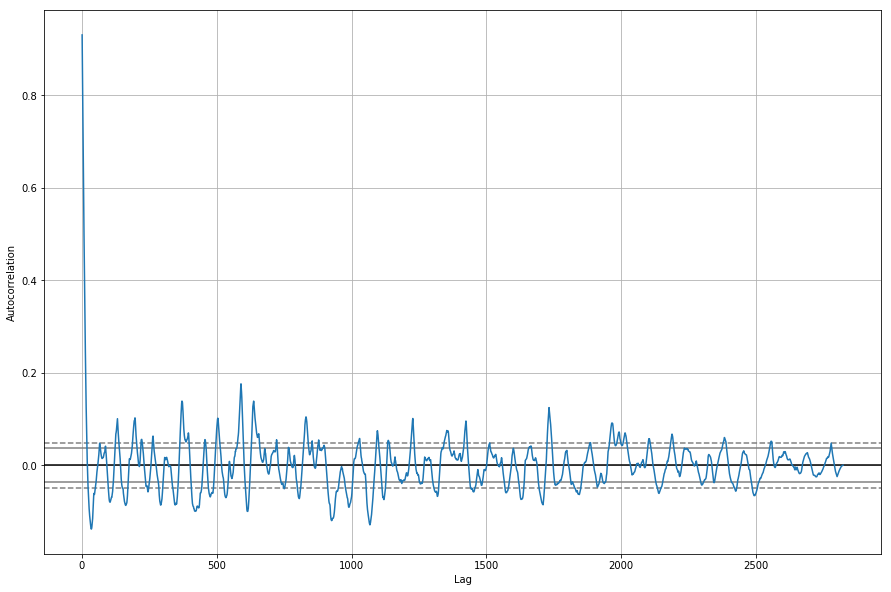

In [203]:
fig, ax = plt.pyplot.subplots(figsize=[15,10])
pd.plotting.autocorrelation_plot(df2['errors'], ax=ax)

Regression w/o intercept shows better R2, but autocorrelation has pretty much the same function.

As a result we can confirm that data is autocorrelated, so OLS estimations will have their significance inflated.

HS: we will use B-P test for heteroskedasticity for each variable based on OLS (TL, variable)

In [206]:
ldrop=list(df2.columns.values)
ldrop.remove('Country Name')
ldrop.remove('Life expectancy')
ldrop.remove('errors')
ldrop.remove('const')
for variable in ldrop:
    reg=sm_lm.OLS(df2['Life expectancy'], df2[['const', variable]]).fit()
    bp=sm_diag.het_breuschpagan(reg.resid, reg.model.exog)
    print(variable)
    print("LM_stat= " + str(bp[0]) + " lm_pvalue= " + str(bp[1]) + " fvalue= " + str(bp[2]) + " f_pvalue= " + str(bp[3]))
    print(" ")

Year
LM_stat= 56.895655821648425 lm_pvalue= 4.595599020060308e-14 fvalue= 58.02520608484492 f_pvalue= 3.509137001576032e-14
 
Education exp. %GNI
LM_stat= 6.157876799025519 lm_pvalue= 0.013082815488723467 fvalue= 6.166969529353968 f_pvalue= 0.01307344438587089
 
Adolescent fertility rate
LM_stat= 68.16774988418827 lm_pvalue= 1.5016167858761535e-16 fvalue= 69.80565162069203 f_pvalue= 1.0132645701621013e-16
 
Age dependency ratio
LM_stat= 35.9692917470824 lm_pvalue= 2.004518574452976e-09 fvalue= 36.407855242334904 f_pvalue= 1.8097889064482659e-09
 
Agriculture v.add. %GDP
LM_stat= 2.608033496123749 lm_pvalue= 0.10632353516710127 fvalue= 2.608595947795333 f_pvalue= 0.10639769542336086
 
Immunization, measles
LM_stat= 10.016430631671138 lm_pvalue= 0.0015514985331386965 fvalue= 10.044985571397875 f_pvalue= 0.0015439946338529982
 
Mobile sub./population
LM_stat= 207.95300127271238 lm_pvalue= 3.8412546234205567e-47 fvalue= 224.3370007787026 f_pvalue= 7.37323984585473e-49
 
Rural population %


No surprise, HS was confirmed for agriculture share of value added, but the other indicators for some reason yielded negative result (fertility rate, immunization, mobile subs, and GDP per capita).